# Notebook 3 - Exploratory Data Analysis (EDA)
This notebook will perform EDA on the cleaned, tokenized, and normalized text to gain further insights into the lyrics pulled from the Genius API, such as descriptive statistics.

In [1]:
# Needed Packages
import pandas as pd

In [7]:
# Read in preprocessed data
preproc_df = pd.read_csv("data/genre_prepped.csv.gz", compression = "gzip")

# drop unnecessary columns (index and unnamed index columns)
preproc_df = preproc_df.drop(preproc_df.columns[0:2], axis = 1)

# Sample Table
preproc_df.head(5)

,artist,title,lyrics,genre,tokens,lyrics_clean
0,Taylor Swift,​betty,"Betty, I won't make assumptions\nAbout why you...",['country'],"['betty', 'make', 'assumptions', 'switched', '...",betty make assumptions switched homeroom think...
1,John Denver,"Take Me Home, Country Roads","Almost Heaven, West Virginia\nBlue Ridge Mount...",['country'],"['almost', 'heaven', 'west', 'virginia', 'blue...",almost heaven west virginia blue ridge mountai...
2,Post Malone,Feeling Whitney,"I've been looking for someone...\nOoh, ooh, oo...",['country'],"['ive', 'looking', 'someone', 'ooh', 'ooh', 'o...",ive looking someone ooh ooh ooh ooh ooh oohooh...
3,Cam,Burning House,\n[Verse 1]\nI had a dream about a burning hou...,['country'],"['1', 'dream', 'burning', 'house', 'stuck', 'i...",1 dream burning house stuck inside get laid be...
4,Johnny Cash,Folsom Prison Blues,"I hear the train a-comin', it's rolling 'round...",['country'],"['hear', 'train', 'acomin', 'rolling', 'round'...",hear train acomin rolling round bend aint seen...


## EDA & Descriptive Statistics

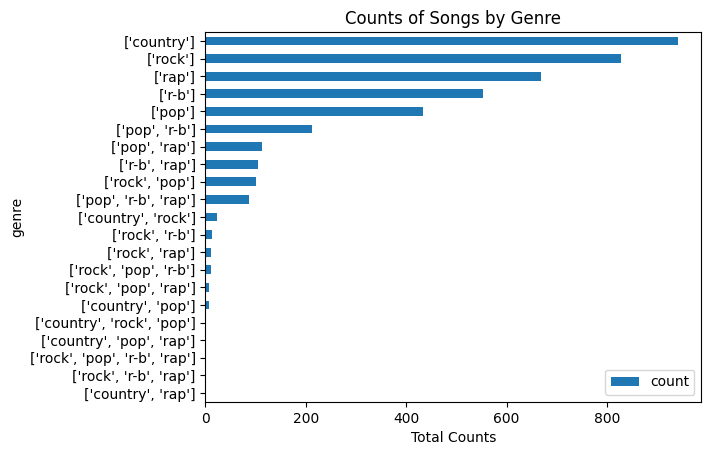

In [26]:
# Plot the total number of songs by genre
pd.DataFrame(preproc_df["genre"].value_counts()).reset_index().sort_values(
    "count", ascending = True).plot(
        kind = "barh",
        x = "genre",
        y = "count",
        title = "Counts of Songs by Genre",
        xlabel = "Total Counts"
    ).legend(loc = "lower right");